In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import random
import operator #for sorting 
from sklearn import preprocessing # for normalization 
from collections import Counter #finding the majority 

#Text Preprocessing 
import re # for number removal 
import string # for punctutation removal 

import nltk 
## for stopword removal
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords= stopwords.words('english')
## lemmatization 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
lemmatizer= WordNetLemmatizer()
from nltk.tokenize import word_tokenize


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/xuyangji/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/xuyangji/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/xuyangji/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [14]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sub_sample=pd.read_csv('sample_submission.csv')
test_lab= pd.read_csv('test_labels.csv')
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [15]:
test_df.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [16]:
#Checking incomplete cases 
train_df.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


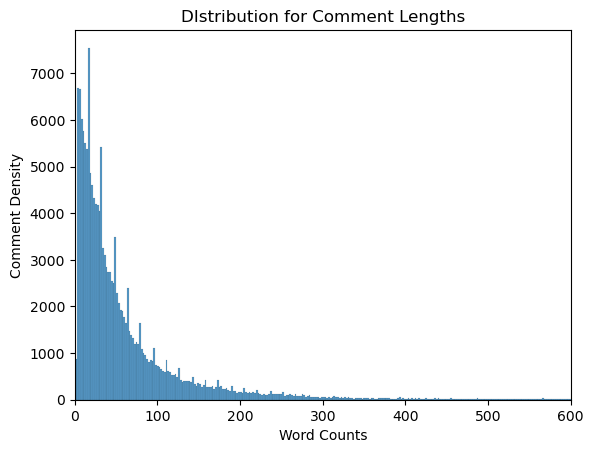

In [17]:
#Checking comment lengths
comm_len = train_df["comment_text"].str.split().apply(len)
sns.histplot(comm_len)
plt.title("DIstribution for Comment Lengths")
plt.xlim(0,600)
plt.xlabel("Word Counts")
plt.ylabel("Comment Density")
plt.show()

In [18]:
# Toxic vs. clean comment 
clean_comm= (train_df.iloc[:,2:].sum(axis=1)==0).sum(axis=0)
clean_comm
print("The clean comment ratio is:",(round(clean_comm/len(train_df),3)))

The clean comment ratio is: 0.898


Text(0.5, 0, 'Comment Class ')

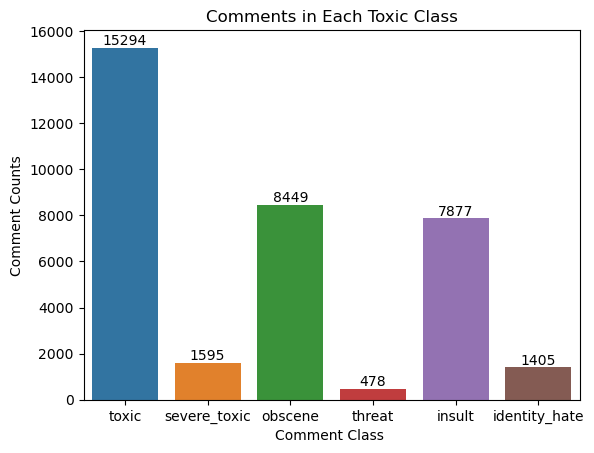

In [7]:
#Ratio of comments in each toxic class

categories= list(train_df.columns.values[2:])
                 
counts=[]
for category in categories:
    count=train_df[category].sum()
    ratio= round(count/len(train_df),3)
    counts.append((category,count,ratio))
category_stat = pd.DataFrame(counts, columns=["Class","Counts","Percentage"])
category_stat

ax= sns.barplot(x="Class",y="Counts",data=category_stat)
ax.bar_label(ax.containers[0])
plt.title("Comments in Each Toxic Class")
plt.ylabel('Comment Counts')
plt.xlabel('Comment Class ')

Text(0.5, 0, 'Classes Counts')

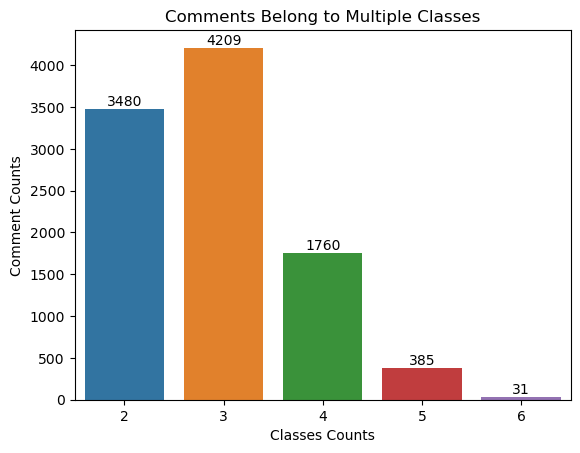

In [8]:
#Comments belong to multiple classes by getting rowSums 
multiClass_comm= train_df.iloc[:,2:].sum(axis=1).value_counts()
multiClass= multiClass_comm[multiClass_comm.index>1]
ax=sns.barplot(x=multiClass.index, y=multiClass.values)
ax.bar_label(ax.containers[0])
plt.title("Comments Belong to Multiple Classes")
plt.ylabel('Comment Counts')
plt.xlabel('Classes Counts')

In [19]:
#Text Preprocessing 

#Removing punctuations'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
def remove_punc(comment):
    nonPunc="".join([letter for letter in comment if letter not in string.punctuation])
    return nonPunc

#Lowering the text
def toLower(comment):
    return comment.lower()

#Removing numbers 
def replace_numbers(comment):
    """Replace all interger occurrences in 
    list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', comment)

#Removing whitespaces
def remove_space(comment):
    return comment.strip()

#Tokenization
def text2word(comment):
    return word_tokenize(comment)

#Removing Stop words
def remove_stopW(words,stopWords):
    return [word for word in words if word not in stopWords]

#Lemmatization
def lematizer(words):
    lemmatizer = WordNetLemmatizer()
    lemm_comm= [lemmatizer.lemmatize(word) for word in words]
    return lemm_comm

def lematizer_verb(words):
    lemmatizer = WordNetLemmatizer()
    lemm_comm= [lemmatizer.lemmatize(word,"v") for word in words]
    return lemm_comm


def clean_comment(comment):
    comment= remove_punc(comment)
    comment= toLower(comment)
    comment= replace_numbers(comment)
    comment= remove_space(comment)
    words=text2word(comment)
    words=remove_stopW(words,stopWords)
    words=lematizer(words)
    words=lematizer_verb(words)
    
    return ' '.join(words)

train_df['comment_text'] = train_df['comment_text'].apply(lambda x: clean_comment(x))
test_df['comment_text'] = test_df['comment_text'].apply(lambda x: clean_comment(x))


In [20]:
train_df["comment_text"].iloc[2]

'hey man im really try edit war guy constantly remove relevant information talk edit instead talk page seem care format actual info'